Author: Adrian Swartz<br>
Date: 3/29/2019


# Solutions to Andew Ng's coursera problems
## Example 8a: Anomaly detection 

This is second to last post! 

Andrew Ng's course is designed for the solutions to be worked through in Octave (similar to matlab). However, I am going to do these problems in python (within a jupyter notebook) and demonstrate how various approaches can be implemented in python.

In this exercise, we are tasked with implementing anomaly detection and apply it to detect failing servers on a network. 

This notebook is structured as follows:<br>

[Anomaly Detection](#pt1)<br>
1. [Exploratory Data Analysis](#eda)
2. [Estimating the Parameters of a Gaussian Distribution](#g)
3. [Model Evaluation](#me)
4. [Outlier Detection with an SVM with a Radial Kernel](#svm)
5. [Unsupervised Outlier Detection with sklearn](#sklearn)
6. [High Dimensional Dataset](#hdd)

***

For this exercise, we will import several python packages: NumPy (numerical python for matrix manupulations and advanced math), pandas (DataFrames offer a useful platform for importing data and performing exploratory data analysis), matplotlib and seaborn for data visualization.

In [1]:
# Import standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
cp=sns.color_palette()

# import a few special packages we'll use for this example
from scipy.io import loadmat

#anomaly detection
from scipy import stats
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from sklearn import svm
from sklearn.covariance import EllipticEnvelope


<a id="pt1"></a>
# Anomaly Detection

Prompt:<br>
Implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While your servers were operating, you collected m = 307 examples of how they were behaving, and thus have an unlabeled dataset {$x(1),...,x(m)$}. You suspect that the vast majority of these examples are “normal” (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

You will use a Gaussian model to detect anomalous examples in your dataset. You will first start on a 2D dataset that will allow you to visualize what the algorithm is doing. On that dataset you will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies. After that, you will apply the anomaly detection algorithm to a larger dataset with many dimensions.

This is kind of a semi-supervised machine learning problem. We have an unlabeled training set, from which we can obtain the general distribution and then set an expected threshold for what we might call an outlier. One approach to validate an unsupervised ML model is to obtain a smaller subset of data and hand label it. We then use this validation set (using the distribution parameters of the training set) to check the quality of the model. 

***

<a id="eda"></a>
# Exploratory Data Analysis



In [2]:
raw_data = loadmat('ex8/ex8data1.mat')
raw_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [3]:
X = raw_data['X']
data = pd.DataFrame(raw_data['X'], columns = ['throughput','latency'])
data.head()

,throughput,latency
0,13.046815,14.741152
1,13.408520,13.763270
2,14.195915,15.853181
3,14.914701,16.174260
4,13.576700,14.042849


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 2 columns):
throughput    307 non-null float64
latency       307 non-null float64
dtypes: float64(2)
memory usage: 4.9 KB


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
throughput,307.0,14.112226,1.355957,4.752613,13.403351,14.059507,14.675503,23.339868
latency,307.0,14.997711,1.309707,4.126232,14.361997,15.023113,15.654394,24.350407


In [6]:
data.corr()

,throughput,latency
throughput,1.000000,-0.128309
latency,-0.128309,1.000000


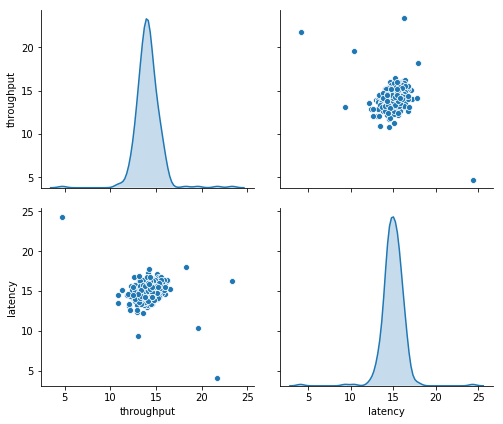

In [7]:
sns.pairplot(data, height=3, aspect=1.2, diag_kind='kde')

The distributions look quasi-normal. The Andrew Ng appraoch of anomaly detection requires that the data be well described by a single gaussian distribution. If the distribution is bimodal or has complex distribution shapes, we would be better served using a more complex probability model (enter sklearn). 

Let's keep pushing forward with the Andrew Ng approach.

Text(0, 0.5, 'latency')

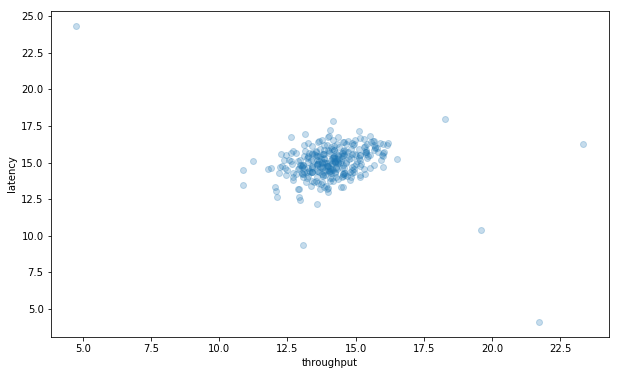

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(X[:,0],X[:,1], alpha=0.25)
cols = data.columns.get_values()
ax.set_xlabel(cols[0])
ax.set_ylabel(cols[1])

There's also, conveniently, some validation data that we will use later

In [9]:
X_val = raw_data['Xval']
y_val = raw_data['yval']
data_val = pd.DataFrame(raw_data['Xval'], columns = ['throughput','latency'])
data_val['anomaly'] = raw_data['yval']
data_val.head()

,throughput,latency,anomaly
0,15.790260,14.921024,0
1,13.639619,15.329955,0
2,14.865899,16.473865,0
3,13.584676,13.989306,0
4,13.464042,15.635330,0


In [10]:
data_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 3 columns):
throughput    307 non-null float64
latency       307 non-null float64
anomaly       307 non-null uint8
dtypes: float64(2), uint8(1)
memory usage: 5.2 KB


In [11]:
data_val.describe().T

,count,mean,std,min,25%,50%,75%,max
throughput,307.0,14.019298,1.589370,0.307938,13.342866,14.031070,14.708025,28.541786
latency,307.0,15.037747,1.277235,5.391413,14.377294,15.020764,15.717998,23.355973
anomaly,307.0,0.029316,0.168966,0.000000,0.000000,0.000000,0.000000,1.000000


In [12]:
print(' ')
print("There are {} / {} anomalies in the X_val set".format(data_val.anomaly.sum(), data_val.anomaly.count()))
print(' ')

 
There are 9 / 307 anomalies in the X_val set
 


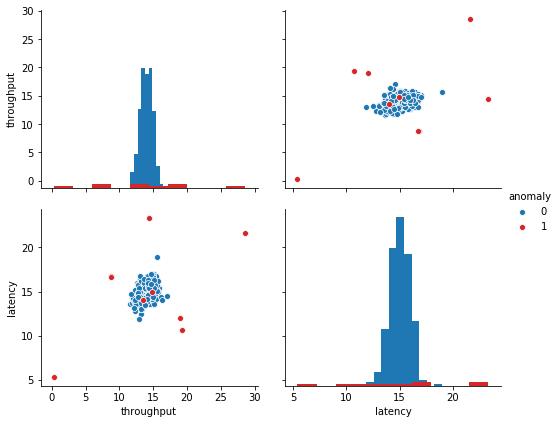

In [13]:
# just love pairplots. They give you such a useful view of the data
sns.pairplot(data_val, vars=['throughput', 'latency'], \
             height=3, aspect=1.2, diag_kind='hist', hue='anomaly', \
             palette={0:cp[0], 1:cp[3]})

<a id="g"></a>
# Estimating the Parameters of a Gaussian Distribution

Given a training set {$x(1),...,x(m)$}, you want to estimate the Gaussian distribution for each of the features $x_i$. For each feature $i = 1...n$, you need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i$-th dimension {$x_i^{(1)}, ..., x_i^{(m)}$} (the $i$-th dimension of each example).

The Gaussian distribution is given by $\frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$ where where $\mu$ is the mean and $\sigma^2$ is the variance.

That's pretty simple. we need the two-dimensional mean and std. deviation.

In [14]:
def get_gaussian_params(X):
    mu = np.mean(X, axis=0)
    variance = np.var(X, axis=0)
    
    return mu, variance

In [15]:
mu, variance = get_gaussian_params(X)
mu, variance

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

__This is actually the model training!__ We are going to use these values of mean and variance on the cross validation data set to check the quality of the model. 

Also, notice that these agree with what data.describe() told us.

We need the probability that each data point belongs to this gaussian distribution (in 2D). So we just need a normal distribution object from `scipy.stats`.  We will need it to predict the probability given a mean and variance in 2D. 

In [16]:
gauss_dist = stats.norm(mu, variance)
gauss_dist.pdf(X)[:5]
# pdf is the probability distribution function. 
# displaying the probabilities for each feature for the first 5 data points

array([[0.183842  , 0.23072208],
       [0.20221694, 0.17979697],
       [0.21746136, 0.20588081],
       [0.19778763, 0.18414102],
       [0.20858956, 0.19964116]])

We can use stats.multivariate_normal, which is a generator object, to help us plot the contours of the probability distribution

Text(0, 0.5, 'latency')

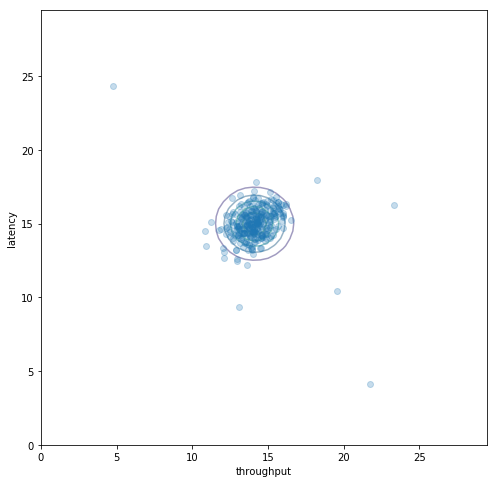

In [17]:
x_, y_ = np.mgrid[0:30:.5, 0:30:.5]
pos = np.dstack((x_, y_))
circles = stats.multivariate_normal(mu, [[variance[0],0], [0,variance[1]]])

fig, ax = plt.subplots(figsize=(8,8))
# plotting on a square so you can see the symmetry more clearly
plt.contour(x_, y_, circles.pdf(pos),5,alpha=0.5)
plt.plot(data.throughput,data.latency,'o',alpha=0.25)

cols = data.columns.get_values()
ax.set_xlabel(cols[0])
ax.set_ylabel(cols[1])

Let's store the probability density of each of the values in our data set based on the 2D Gaussian model parameters.

Do this for X and X_val (using the same model parameters). We'll use the labeled data from the validation set to evaluate the performance of our model. We will tune the probability threshold to best optimize for precision/recall in detecting anomolies. 

Remember that $\mu$ and $\sigma^2$ were "trained" on the training set, not the X_val set.

In [18]:
p = stats.multivariate_normal(mu, [[variance[0],0], [0,variance[1]]]).pdf(X)
p_val = stats.multivariate_normal(mu, [[variance[0],0], [0,variance[1]]]).pdf(X_val)

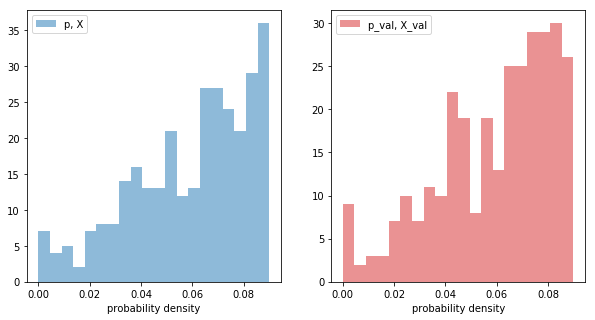

In [19]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.hist(p, color=cp[0], bins = 20, alpha = 0.5, label='p, X')
ax2.hist(p_val, color=cp[3], bins = 20, alpha = 0.5, label='p_val, X_val')
ax1.set_xlabel('probability density')
ax2.set_xlabel('probability density')
ax1.legend()
ax2.legend()

<a id="me"></a>
# Model Evaluation
Let's find the threshold, but we first need to build up a metric framework for the classifier. We'll be validating on the labeled cross validation data set.

In [20]:
threshold = 0.02
y_val_pred = np.array([1 if i < threshold else 0 for i in p_val ]) # love list comprehension
y_val_pred.sum()

20

A threshold for the probability density of of 0.02 predicts 20 outliers for the validation set. (We know there are only 9.)

In [21]:
def get_metrics(y_data, y_pred):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_data, y_pred)
    
    # true positives / (true positives + false negatives)
    recall = recall_score(y_data, y_pred)
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_data, y_pred)
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_data, y_pred)
    return accuracy, precision, recall, f1

In [22]:
acc, prec, rec, f1 = get_metrics(y_val, y_val_pred)
print(' ')
print('Accuracy: {:.2}; Precision: {:.2}; Recall: {:.2}; F1 Score: {:.2}'.format(acc, prec, rec, f1))

 
Accuracy: 0.95; Precision: 0.35; Recall: 0.78; F1 Score: 0.48


Precision is low. With a high accuracy, that means TP/(TP+FN) that there are probably a lot of false negatives. We can check by looking at the truth table. 

Text(24.0, 0.5, 'Actual')

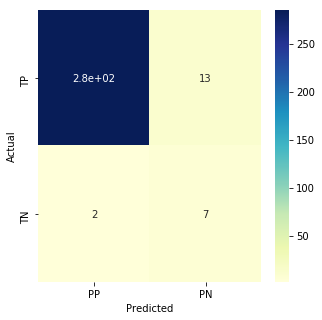

In [23]:
conf = confusion_matrix(y_val, y_val_pred)

# Seaborn has a nice heatmap plot that's great for confusion matrices.
df_cm = pd.DataFrame(conf.astype(int), index = ['TP','TN'], columns = ['PP','PN'])
plt.figure(figsize = (5,5))
ax = sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

Remember that false negatives are when the model predicts a negative (in this case an anomaly) when in fact they should be a positive (in this case not an anomaly) (i.e. the 13 in the top right corner are false negatives). However, notice that the 9 anomalies are mostly accounted for. 7 of them make are correctly classified as anomalies. From the truth table, we could guess that our probability threshold is too high and we are predicting that too many inliers are outliers. We need to sweep the threshold value and track accuracy, precision, recall, and f1. 

In [24]:
def sweep_thresholds(p_val,y_val):
    
    step = (p_val.max() - p_val.min()) / 1000
    thrs = np.arange(p_val.min()+step, p_val.max()+step, step)
    
    accs = np.zeros(len(thrs))
    precs = np.zeros(len(thrs))
    recs = np.zeros(len(thrs))
    f1s = np.zeros(len(thrs))
    
    
    for i, thresh in enumerate(thrs):
        
        y_val_pred = np.array([1 if i < thresh else 0 for i in p_val ])

        accs[i], precs[i], recs[i], f1s[i] = get_metrics(y_val,y_val_pred)
        
        
    return thrs, accs, precs, recs, f1s


In [25]:
ths, accs, precs, recs, f1s = sweep_thresholds(p_val,y_val)

Text(0.5, 0, 'Probability Density Threshold')

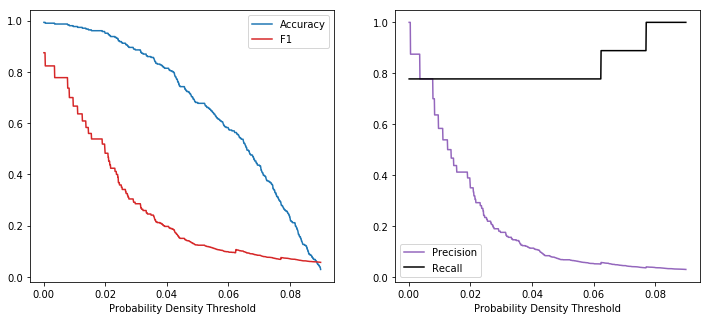

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(ths, accs, label='Accuracy')
ax1.plot(ths, f1s, c=cp[3], label='F1')
ax2.plot(ths, precs, c=cp[4], label='Precision')
ax2.plot(ths, recs, c='black', label='Recall')
ax1.legend()
ax2.legend()
ax1.set_xlabel('Probability Density Threshold')
ax2.set_xlabel('Probability Density Threshold')

I think that sweep range was too big. It seems we missed a lot of the action. We already knew that 0.02 was giving too many False Negatives. Let's try a log-scale sweep range.

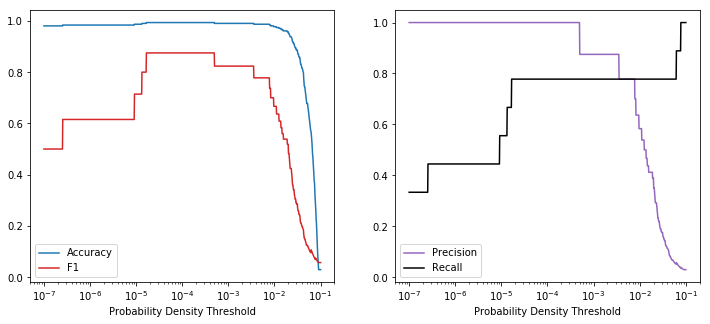

In [27]:
def sweep_thresholds(p_val,y_val):
    

    thrs = np.logspace(-7,-1, num=1000)
    
    accs = np.zeros(len(thrs))
    precs = np.zeros(len(thrs))
    recs = np.zeros(len(thrs))
    f1s = np.zeros(len(thrs))
    
    
    for i, thresh in enumerate(thrs):
        
        y_val_pred = np.array([1 if i < thresh else 0 for i in p_val ])

        accs[i], precs[i], recs[i], f1s[i] = get_metrics(y_val,y_val_pred)
        
        
    return thrs, accs, precs, recs, f1s


ths, accs, precs, recs, f1s = sweep_thresholds(p_val,y_val)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(ths, accs, label='Accuracy')
ax1.plot(ths, f1s, c=cp[3], label='F1')
ax2.plot(ths, precs, c=cp[4], label='Precision')
ax2.plot(ths, recs, c='black', label='Recall')
ax1.legend()
ax2.legend()
ax1.set_xlabel('Probability Density Threshold')
ax2.set_xlabel('Probability Density Threshold')
ax1.set_xscale('log')
ax2.set_xscale('log')

That's better. We've found it. Probability density threshold of 1E-4 maximizes F1, accuracy and precison are high, with a reasonable tradeoff for recall. This threshold is the same result as given in `ex8.pdf`.

Text(17.200000000000003, 0.5, 'Actual')

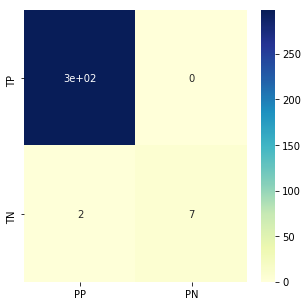

In [28]:
threshold = 1E-4
y_val_pred = np.array([1 if i < threshold else 0 for i in p_val])
conf = confusion_matrix(y_val, y_val_pred)

# Seaborn has a nice heatmap plot that's great for confusion matrices.
df_cm = pd.DataFrame(conf.astype(int), index = ['TP','TN'], columns = ['PP','PN'])
plt.figure(figsize = (5,5))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

There are 9 anomalies in this validation set and it classifies 7 of them correctly and falsy predicts that 2 of them are not anomalies. However, the precision is extremely high. The model isn't misclassifying any non-anomalies (no false negatives)



In [29]:
# indexes of the values prediceted to be outliers
outliers = np.where(p_val < 1E-4)

# indexes of the values predicted to be not anomalies
inliers = np.where(p_val > 1E-4)

not_anomalies = data_val.iloc[inliers]
false_positives = not_anomalies[(not_anomalies.anomaly==1)]
true_positives = not_anomalies[(not_anomalies.anomaly==0)]


In [30]:
false_positives

,throughput,latency,anomaly
9,14.859341,14.900665,1
49,13.551726,14.018418,1


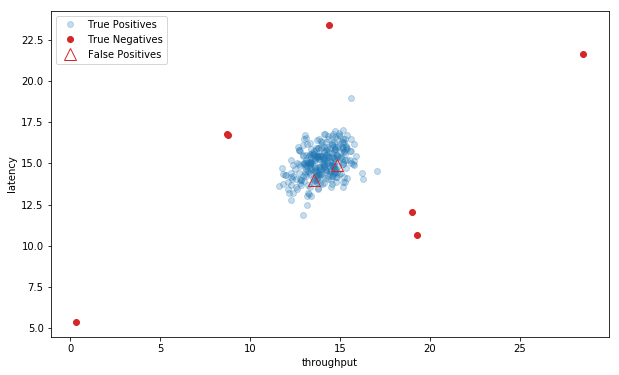

In [31]:

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(true_positives.throughput, true_positives.latency,\
         'o',c=cp[0], alpha=0.25, label='True Positives')

ax.plot(data_val.throughput.iloc[outliers], data_val.latency.iloc[outliers],\
         'o',c=cp[3], alpha=1, label='True Negatives')

plt.plot(false_positives.throughput, false_positives.latency,\
         '^', markersize=12, c=cp[3], alpha=1, label='False Positives', fillstyle='none')

cols = data.columns.get_values()
ax.set_xlabel(cols[0])
ax.set_ylabel(cols[1])
ax.legend()

Well, that looks pretty reasonable. We caught all the obvious outliers and set a threshold which properly classified all the non-anomalies (i.e. optimized for precision). Because of that choice, we missed the two servers which broke down in the center. However, those two look like they were within the normal operating conditions. We would need more information than just throughput and latency to undersstand why they failed.

<a id="svm"></a>
# Outlier Detection with an SVM with a Radial Kernel (Binary Classification)
We could also have done this with sklearn. See for instance their extensive documentation on [outlier and novelty detection](https://scikit-learn.org/stable/modules/outlier_detection.html). However, because of the symmetry of the problem, I think we can try a radial basis kernel SVM and get half decent results. Let's try it.

There is a major problem with using a binary classifier here - we have to have labeled data. In that case, we can only train the model on the validation set. This is not a good practice (it's in fact a horrible practice), but we just want to explore a little bit how a rbf SVM can perform. 

In [32]:
svc = svm.SVC(C=1, kernel='rbf', gamma=1, probability=True).fit(X_val, y_val.ravel())

In [33]:
svc.score(X_val, y_val)

0.993485342019544

In [34]:
get_metrics(y_val, svc.predict(X_val))

(0.993485342019544, 1.0, 0.7777777777777778, 0.8750000000000001)

Text(17.200000000000003, 0.5, 'Actual')

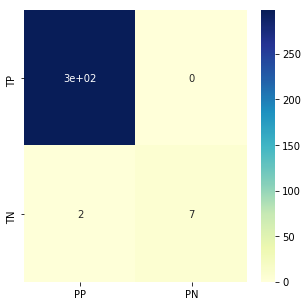

In [35]:
conf = confusion_matrix(y_val, svc.predict(X_val))

# Seaborn has a nice heatmap plot that's great for confusion matrices.
df_cm = pd.DataFrame(conf.astype(int), index = ['TP','TN'], columns = ['PP','PN'])
plt.figure(figsize = (5,5))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

Looks good. Let's look at the probabilities that the SVC provides.

In [36]:
y_val_probas = svc.predict_proba(X_val)
y_val_probas.shape

(307, 2)

(array([300.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   7.]),
 array([0.00676809, 0.10609128, 0.20541447, 0.30473766, 0.40406086,
        0.50338405, 0.60270724, 0.70203043, 0.80135362, 0.90067681,
        1.        ]),
 <a list of 10 Patch objects>)

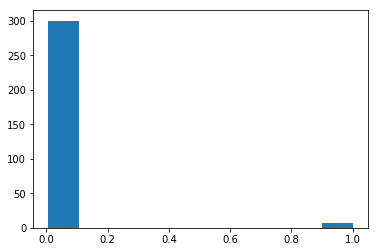

In [37]:
plt.hist(y_val_probas[:,1])

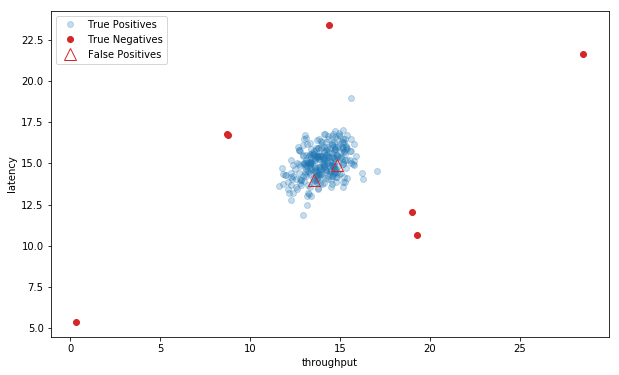

In [38]:
inliers = np.where(y_val_probas[:,1] < 0.2)
outliers = np.where(y_val_probas[:,1] > 0.8)

not_anomalies = data_val.iloc[inliers]
false_positives = not_anomalies[(not_anomalies.anomaly==1)]
true_positives = not_anomalies[(not_anomalies.anomaly==0)]

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(true_positives.throughput, true_positives.latency,\
         'o',c=cp[0], alpha=0.25, label='True Positives')

ax.plot(data_val.throughput.iloc[outliers], data_val.latency.iloc[outliers],\
         'o',c=cp[3], alpha=1, label='True Negatives')

plt.plot(false_positives.throughput, false_positives.latency,\
         '^', markersize=12, c=cp[3], alpha=1, label='False Positives', fillstyle='none')

cols = data.columns.get_values()
ax.set_xlabel(cols[0])
ax.set_ylabel(cols[1])
ax.legend()

Text(0.5, 1.0, 'RBF SVM Probabilities')

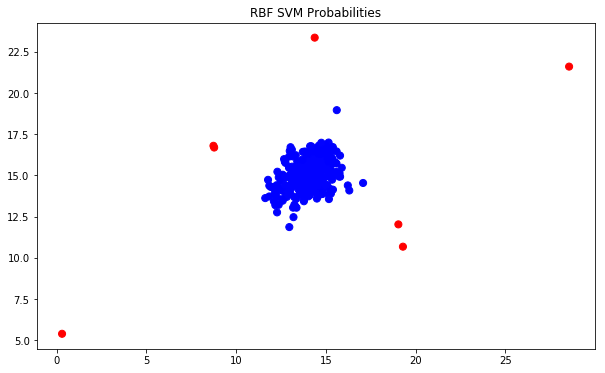

In [39]:
#lastly, let's just plot the probabilities given by the svc as a color scale 
data_val['predicted_probabilities'] = y_val_probas[:,1]

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(data_val.throughput, data_val.latency, s=50, c=data_val.predicted_probabilities, cmap='bwr')
ax.set_title('RBF SVM Probabilities')

So we've arrived at the same result as the multi-variate gaussian probability version of anomaly detection. I didn't even need to do a grid search with this radial SVM in order to get a high quality result

Let's do a lazy search over $\gamma$ and $C$ just to get a better sense of what kind of range of kernel widths the model is sensitive to.

In [40]:
def sweep_gamma(X_val,y_val):
    gammas = np.logspace(-3,3, num=50)
    
    accs = np.zeros(len(gammas))
    precs = np.zeros(len(gammas))
    recs = np.zeros(len(gammas))
    f1s = np.zeros(len(gammas))
       
    for i, g in enumerate(gammas):   
        svc = svm.SVC(C=1, kernel='rbf', gamma=g).fit(X_val, y_val.ravel())
        accs[i], precs[i], recs[i], f1s[i] = get_metrics(y_val, svc.predict(X_val))
    
    return gammas, accs, precs, recs, f1s


gammas, accs, precs, recs, f1s = sweep_gamma(X_val,y_val)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samp

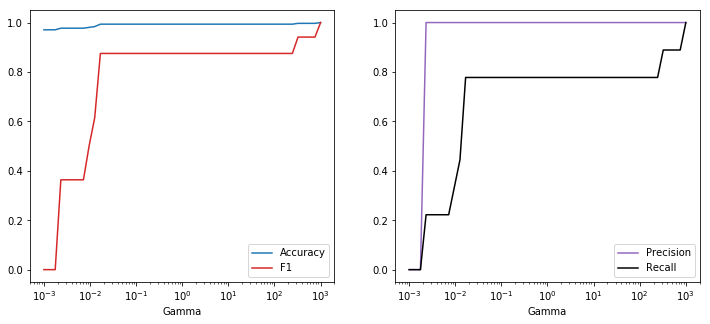

In [41]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(gammas, accs, label='Accuracy')
ax1.plot(gammas, f1s, c=cp[3], label='F1')
ax2.plot(gammas, precs, c=cp[4], label='Precision')
ax2.plot(gammas, recs, c='black', label='Recall')
ax1.legend()
ax2.legend()
ax1.set_xlabel('Gamma')
ax2.set_xlabel('Gamma')
ax1.set_xscale('log')
ax2.set_xscale('log')

In [42]:
def sweep_C(X_val,y_val):
    Cs = np.logspace(-2,2, num=50)
    
    accs = np.zeros(len(Cs))
    precs = np.zeros(len(Cs))
    recs = np.zeros(len(Cs))
    f1s = np.zeros(len(Cs))
       
    for i, c in enumerate(Cs):   
        svc = svm.SVC(C=c, kernel='rbf', gamma=1).fit(X_val, y_val.ravel())
        accs[i], precs[i], recs[i], f1s[i] = get_metrics(y_val, svc.predict(X_val))
    
    return Cs, accs, precs, recs, f1s


Cs, accs, precs, recs, f1s = sweep_C(X_val,y_val)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samp

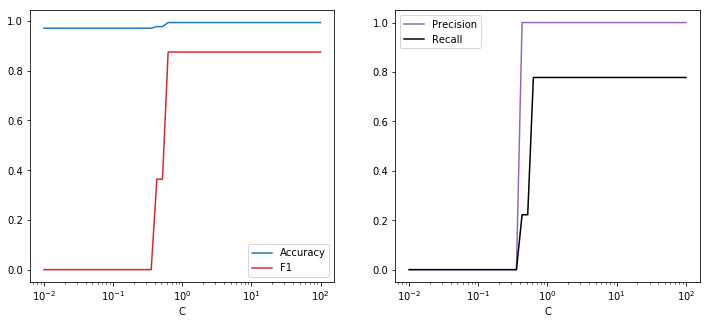

In [43]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(Cs, accs, label='Accuracy')
ax1.plot(Cs, f1s, c=cp[3], label='F1')
ax2.plot(Cs, precs, c=cp[4], label='Precision')
ax2.plot(Cs, recs, c='black', label='Recall')
ax1.legend()
ax2.legend()
ax1.set_xlabel('C')
ax2.set_xlabel('C')
ax1.set_xscale('log')
ax2.set_xscale('log')

Can see from this that $\gamma$, the width of the radial kernel, provides much better sensitivity than regularization for this problem. There are a major conceptual differences between radial kernel SVM and "Anomaly Detection" as I have implemented it above. However, because of the geometry of the problem in feature space, a non-linear SVM is pretty good at finding strange boundaries for outlier classification problems. 


<a id="sklearn"></a>
# Unsupervised Outlier Detection with sklearn

There are other outlier detection algorithms built in to sklearn. They include anomaly detection by gaussian probabilities (simple z-score) and [elliptical covariance](https://scikit-learn.org/0.17/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope) (same concept as the Andrew Ng appraoch described above), [DBSCAN](https://mikulskibartosz.name/outlier-detection-with-scikit-learn-d9246b33d352) (Density Based Spacial Clustering of Applications with Noise), [isolation forests](https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e) (based on random forests), [and one-class SVM](https://scikit-learn.org/0.17/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM) (as opposed to the binary classification problem - Again, in general, training on validation set is an unacceptable practice, but for the radial svm I was just trying to get a feel for how the model functions). 

Because the data is well descibed by a gaussian (i.e. not bimodal), I will next use EllipticEnvelope which fits an ellipsoidal Gaussian encompasing the smallest volume while discarding some fixed fraction of "contamination." The degree of contamination is set as a hyperparameter 

(array([ 33.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 274.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

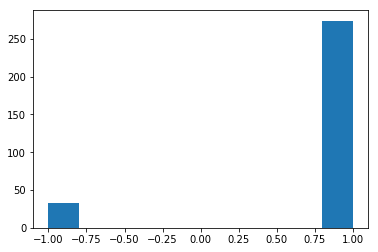

In [44]:
# as usual, just a couple of lines to "train" a model in sklearn
cont = 0.1  # chosen arbitrarily for now.
ell = EllipticEnvelope(contamination=cont)
ell.fit(X)



y_val_pred = ell.predict(X_val)   

# Note that outlier points are predicted as -1, which is weird
plt.hist(y_val_pred)

In [45]:
def convert_Elliptic_prediction(y_val_pred):
    for i, val in enumerate(y_val_pred):
        if val == 1:
            y_val_pred[i] = 0
        elif val == -1:
            y_val_pred[i] = 1

    return y_val_pred

y_val_pred = convert_Elliptic_prediction(y_val_pred)

y_val_pred.sum()

33

In [46]:
acc, prec, rec, f1 = get_metrics(y_val, y_val_pred)
print(' ')
print('Accuracy: {:.2}; Precision: {:.2}; Recall: {:.2}; F1 Score: {:.2}'.format(acc, prec, rec, f1))

 
Accuracy: 0.91; Precision: 0.21; Recall: 0.78; F1 Score: 0.33


OK. Again the arbitrary threshold is too generous in choosing outliers. Let's sweep over contamination value. 

In [47]:
def sweep_contamination(X_val,y_val):
    contams = np.linspace(.005,.5, num=500)
    
    
    accs = np.zeros(len(contams))
    precs = np.zeros(len(contams))
    recs = np.zeros(len(contams))
    f1s = np.zeros(len(contams))
       
    for i, c in enumerate(contams):   
        ell = EllipticEnvelope(contamination=c)
        ell.fit(X)
        y_val_pred = ell.predict(X_val) 
        y_val_pred = convert_Elliptic_prediction(y_val_pred)
        accs[i], precs[i], recs[i], f1s[i] = get_metrics(y_val, y_val_pred)
    
    return contams, accs, precs, recs, f1s


contams, accs, precs, recs, f1s = sweep_contamination(X_val,y_val)

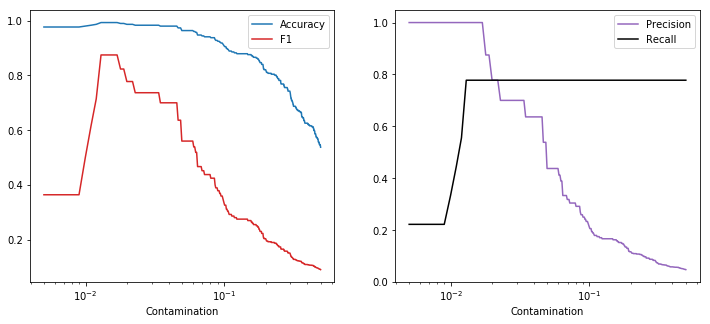

In [48]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(contams, accs, label='Accuracy')
ax1.plot(contams, f1s, c=cp[3], label='F1')
ax2.plot(contams, precs, c=cp[4], label='Precision')
ax2.plot(contams, recs, c='black', label='Recall')
ax1.legend()
ax2.legend()
ax1.set_xlabel('Contamination')
ax2.set_xlabel('Contamination')
ax1.set_xscale('log')
ax2.set_xscale('log')

In [49]:
opt_index = int(np.median(np.where(f1s == np.max(f1s))))

opt_acc = accs[opt_index]
opt_prec = precs[opt_index]
opt_rec = recs[opt_index]
opt_f1 = f1s[opt_index]
opt_contam = contams[opt_index]

print('Optimal Model Performance')
print('Accuracy: {:.2}; Precision: {:.2}; Recall: {:.2}; F1 Score: {:.2}'.format(\
                                        opt_acc, opt_prec, opt_rec, opt_f1))
print('Best Contamination: {:.3}'.format(opt_contam))

Optimal Model Performance
Accuracy: 0.99; Precision: 1.0; Recall: 0.78; F1 Score: 0.88
Best Contamination: 0.0149


Text(3.200000000000003, 0.5, 'Actual')

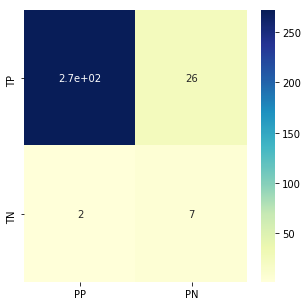

In [50]:
conf = confusion_matrix(y_val, y_val_pred)

# Seaborn has a nice heatmap plot that's great for confusion matrices.
df_cm = pd.DataFrame(conf.astype(int), index = ['TP','TN'], columns = ['PP','PN'])
plt.figure(figsize = (5,5))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

And we've reached the optimal performance. Easy!


<a id="hdd"></a>
# High Dimensional Dataset

Run the anomaly detection algorithm on a more realistic and much harder dataset. In this dataset, each example is described by 11 features, capturing many more properties of your compute servers.

In [51]:
raw_data = loadmat('ex8/ex8data2.mat')
raw_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [52]:
X = raw_data['X']
cols = ['X' + str(i) for i in range(1,12)]
data = pd.DataFrame(raw_data['X'], columns = cols)
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11
0,6.653114,13.689702,17.552845,-11.933497,-5.756409,15.435921,-12.136752,8.224123,-4.884024,5.349335,17.351372
1,-5.630542,-18.937667,18.644624,-6.155825,-25.988864,15.409553,-16.595516,9.454654,-2.877173,-6.009420,19.210636
2,9.721525,-9.982489,15.571434,-32.224266,-5.595799,24.321383,0.832774,10.794555,0.727575,10.392975,7.085995
3,-4.635766,-10.716040,20.356571,-9.002097,-4.920569,-4.261957,-1.305829,0.949980,-8.634107,0.198445,0.006771
4,-12.841044,-20.388313,9.491936,-7.038500,-9.921087,-3.716105,-9.384730,-2.325534,-13.518562,11.007029,14.003210


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
X1     1000 non-null float64
X2     1000 non-null float64
X3     1000 non-null float64
X4     1000 non-null float64
X5     1000 non-null float64
X6     1000 non-null float64
X7     1000 non-null float64
X8     1000 non-null float64
X9     1000 non-null float64
X10    1000 non-null float64
X11    1000 non-null float64
dtypes: float64(11)
memory usage: 86.0 KB


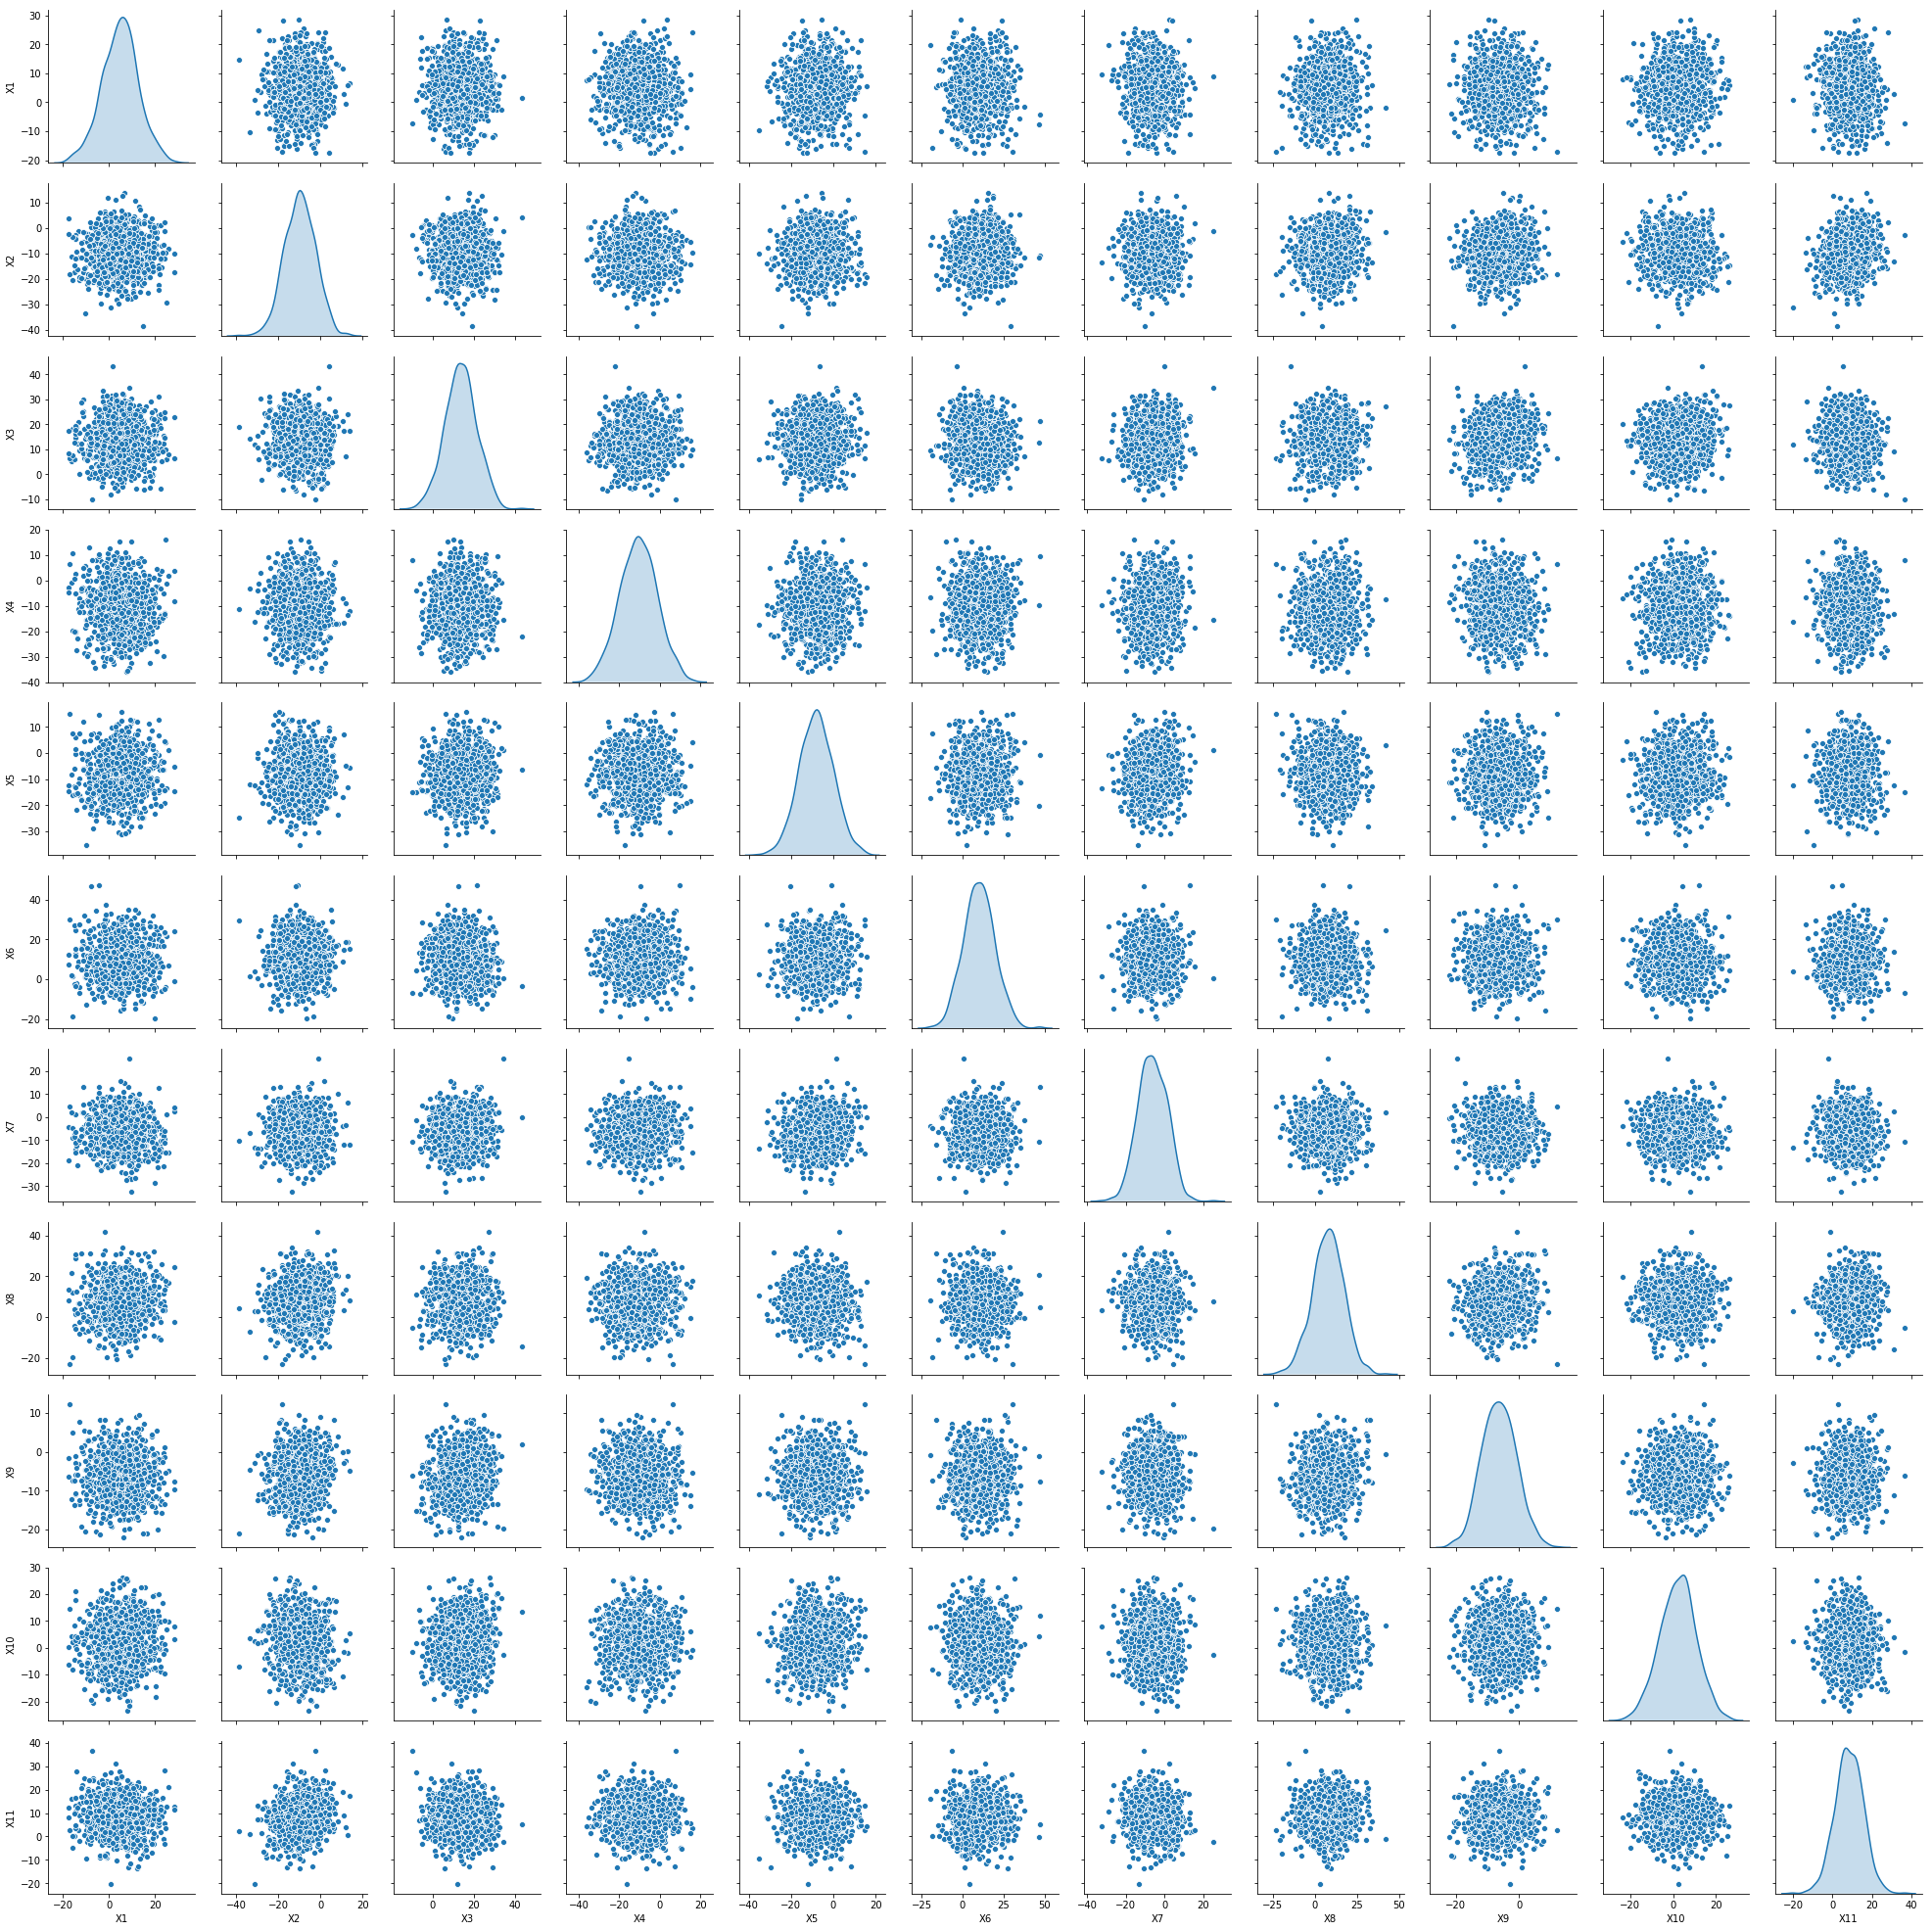

In [54]:
sns.pairplot(data, diag_kind='kde')

LOL

In [55]:
X_val = raw_data['Xval']
y_val = raw_data['yval']
X_val.shape

(100, 11)

In [56]:
data_val = pd.DataFrame(raw_data['Xval'], columns = cols)
data_val.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11
0,18.271283,-12.359268,5.000970,1.611472,1.088592,29.314410,-8.313531,36.438338,-9.476679,-25.928183,7.108628
1,-3.193070,-19.705821,6.528556,-21.570858,3.050556,23.477503,-1.133420,12.688409,-10.968301,-1.198666,1.908441
2,-5.256678,-12.918720,25.435141,-7.231568,3.647838,12.366550,-6.512076,8.750902,-0.768755,-3.261094,13.729474
3,12.953176,-10.350333,19.857858,-24.424608,3.266105,30.445294,-11.125842,12.815629,9.351355,-6.113624,17.627375
4,3.763819,-5.728187,11.400169,-17.555297,-6.246576,16.155969,-9.724758,16.996616,-5.168654,0.187994,11.401234


In [57]:
data_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
X1     100 non-null float64
X2     100 non-null float64
X3     100 non-null float64
X4     100 non-null float64
X5     100 non-null float64
X6     100 non-null float64
X7     100 non-null float64
X8     100 non-null float64
X9     100 non-null float64
X10    100 non-null float64
X11    100 non-null float64
dtypes: float64(11)
memory usage: 8.7 KB


In [58]:
y_val.sum() # There are 10 errors in the validation set

10

(array([ 8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 92.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

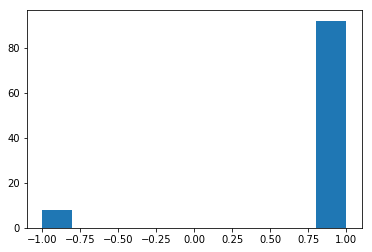

In [59]:
# Train the model in using EllipticEnvelope
cont = 0.02  # chosen based on previous result
ell = EllipticEnvelope(contamination=cont)
ell.fit(X)

y_val_pred = ell.predict(X_val)   

# Note that outlier points are predicted as -1, which is weird
plt.hist(y_val_pred)

In [60]:
y_val_pred = convert_Elliptic_prediction(y_val_pred)

y_val_pred.sum()

8

In [61]:
# Searching for the best threshold
contams, accs, precs, recs, f1s = sweep_contamination(X_val,y_val)

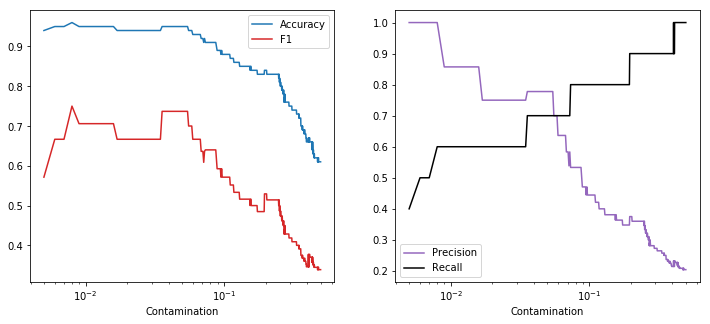

In [62]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(contams, accs, label='Accuracy')
ax1.plot(contams, f1s, c=cp[3], label='F1')
ax2.plot(contams, precs, c=cp[4], label='Precision')
ax2.plot(contams, recs, c='black', label='Recall')
ax1.legend()
ax2.legend()
ax1.set_xlabel('Contamination')
ax2.set_xlabel('Contamination')
ax1.set_xscale('log')
ax2.set_xscale('log')

In [63]:
opt_index = int(np.median(np.where(f1s == np.max(f1s))))

opt_acc = accs[opt_index]
opt_prec = precs[opt_index]
opt_rec = recs[opt_index]
opt_f1 = f1s[opt_index]
opt_contam = contams[opt_index]

print('Optimal Model Performance')
print('Accuracy: {:.2}; Precision: {:.2}; Recall: {:.2}; F1 Score: {:.2}'.format(\
                                        opt_acc, opt_prec, opt_rec, opt_f1))
print('Best Contamination: {:.3}'.format(opt_contam))

Optimal Model Performance
Accuracy: 0.96; Precision: 1.0; Recall: 0.6; F1 Score: 0.75
Best Contamination: 0.00798


Text(3.200000000000003, 0.5, 'Actual')

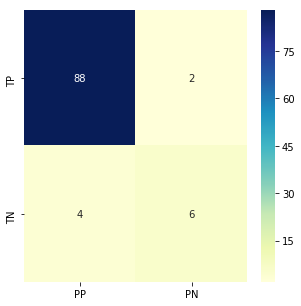

In [64]:
conf = confusion_matrix(y_val, y_val_pred)

# Seaborn has a nice heatmap plot that's great for confusion matrices.
df_cm = pd.DataFrame(conf.astype(int), index = ['TP','TN'], columns = ['PP','PN'])
plt.figure(figsize = (5,5))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

Text(3.200000000000003, 0.5, 'Actual')

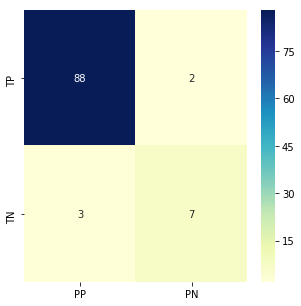

In [65]:
ell = EllipticEnvelope(contamination=.045)
ell.fit(X)

y_val_pred = ell.predict(X_val)   
y_val_pred = convert_Elliptic_prediction(y_val_pred)

conf = confusion_matrix(y_val, y_val_pred)


# Seaborn has a nice heatmap plot that's great for confusion matrices.
df_cm = pd.DataFrame(conf.astype(int), index = ['TP','TN'], columns = ['PP','PN'])
plt.figure(figsize = (5,5))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

Done! On to collaborative filtering